<a href="https://colab.research.google.com/github/MayerT1/Pakistan_Research/blob/main/Step_5_Forest_Structure_Function_Module_Python_PFI_Test_ROI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluation / Comparison module for mapping forest strucure with GEDI

*   Author T. Mayer 7/24/24; NASA SERVIR, Univeristy of Alabama in Huntsville, and University of Twente ITC
*   Script for cross comparsing various canopy Height Modles and in situ to compare RF model products
*   Similar function as used here are offered in a a GEE JS. See the Github
*   Recommend to use this notebook as the charting is more robust in python




In [1]:
!pip install geemap

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)


In [ ]:
# import ee
# import geemap
# import geemap.chart as chart

In [2]:
!pip install scikit-plot

In [3]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 35.3 MB/s eta 0:00:00


In [4]:
!pip install xarray

In [5]:
# Import seaborn
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import rasterio
import xarray as xr
import scipy
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [6]:
import ee
import geemap
import geemap.chart as chart
ee.Authenticate()
ee.Initialize(project='servir-sco-assets')
Map = geemap.Map()

In [ ]:
js_snippet = """


"""

In [ ]:
geemap.js_snippet_to_py(
    js_snippet, add_new_cell=True, import_ee=True, import_geemap=True, show_map=True
)

print("canopy_ht_gte_only", canopy_ht_gte_only.getInfo())


In [ ]:
lines = geemap.js_snippet_to_py(js_snippet, add_new_cell=False, import_ee=True, import_geemap=True, show_map=True)
for line in lines:
    print(line.rstrip())

In [7]:
Regression_Predicted_Image = ee.Image("projects/servir-sco-assets/assets/SCO_HKH/KP_Height_Prelim/Regression_Predicted_Image_PFI_Test_ROI")
Map.addLayer(Regression_Predicted_Image, {}, 'Regression_Predicted_Image')


ROI = Regression_Predicted_Image.geometry()
Map.addLayer(ROI, {}, 'ROI')
Map.centerObject(ROI,10);



# ROI = ee.Geometry.Rectangle([24.483975980464127,-33.345729637978984,23.649015042964127,-33.83078248926919])
# # Map.addLayer(ROI, {}, 'ROI')
# # Map.centerObject(ROI,10);

# SA_prediction = ee.Image('projects/servir-sco-assets/assets/SCO_Global/SA_Rest/SA_Rest_Regression_Predicted_Image')
# # Map.addLayer(SA_prediction, {}, "SA_prediction")

Map

Map(center=[34.344342372627665, 72.75989984828747], controls=(WidgetControl(options=['position', 'transparent_…

In [42]:
glad = ee.Image("projects/glad/GLCLU2020/Forest_height_2020")
canopy_ht = ee.ImageCollection("projects/meta-forest-monitoring-okw37/assets/CanopyHeight")
in_situ = ee.FeatureCollection('users/tjm0042/PHD/SA_Rest/Height_Avg_max_xycsv')
eth = ee.Image('users/nlang/ETH_GlobalCanopyHeight_2020_10m_v1').select("b1").rename('eth')
UMD_TCH = ee.Image("users/tjm0042/PHD/GEDI_Height/UMD_TCH_FC").select('TCH_2021_b1')

# Glad

In [10]:
#/toggle off these two lines for bareground concerns
glad_add_gte = glad.gte(1).clip(ROI);
glad_add_gte_only = glad.updateMask(glad_add_gte)

###/Glad
stacked_Comp_glad = Regression_Predicted_Image.addBands(glad_add_gte_only)
#print("stacked_Comp_glad", stacked_Comp_glad)
Map.addLayer(stacked_Comp_glad, {}, "stacked_Comp_glad")

##Random sample approach
rand_Pts = ee.FeatureCollection.randomPoints(stacked_Comp_glad.geometry(), 1000, 42, 10)
#print("rand_Pts", rand_Pts)
Map.addLayer(rand_Pts, {}, "rand_Pts")

glad_sample = stacked_Comp_glad.sample(**
 {'region':rand_Pts, 'scale':1, 'numPixels': 500000, 'seed':42,"geometries": True}
                                       )
# print("glad_sample", glad_sample.getInfo())
# print("glad_sample", glad_sample.first())
#Map.addLayer(glad_sample, {} , "glad_sample", False)

#Map

In [11]:
glad_sample_df = geemap.ee_to_df(glad_sample)
print("glad_sample_df", glad_sample_df)
y_true_glad = glad_sample_df['b1']
print('y_true', y_true_glad.shape)
y_pred_glad = glad_sample_df['classification']
print('y_pred', y_pred_glad.shape)

print("MAE",mean_absolute_error(y_true_glad,y_pred_glad))

print("MSE",mean_squared_error(y_true_glad,y_pred_glad))

r2 = r2_score(y_true_glad,y_pred_glad)
print("R2", r2)

print("RMSE",np.log(np.sqrt(mean_squared_error(y_true_glad,y_pred_glad))))

glad_sample_df      b1  classification
0    11       15.602602
1     7       21.222681
2     8       26.165712
3     9       16.258160
4    11       20.041582
..   ..             ...
526  12       18.104631
527  11       19.868509
528  20       20.712744
529  19       14.812960
530   8       13.528916

[531 rows x 2 columns]
y_true (531,)
y_pred (531,)
MAE 6.937364576451073
MSE 63.660561976785544
R2 -1.0186232445409877
RMSE 2.0767826247999315


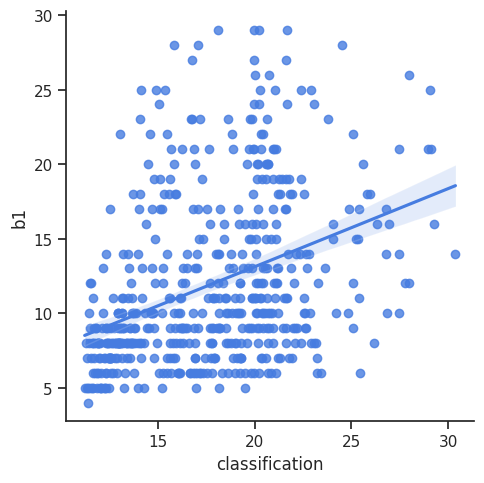

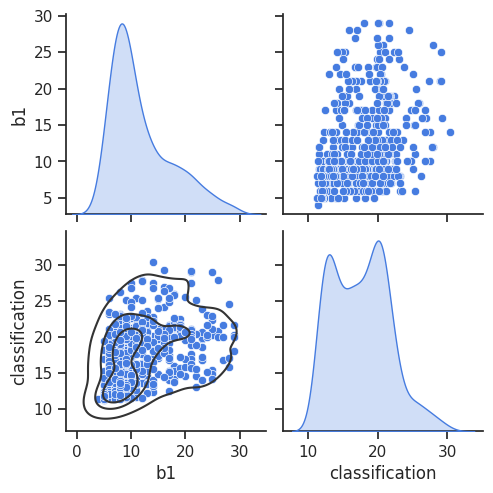

In [54]:
# sns.relplot(data=glad_sample_df, x='classification', y='b1')
# sns.pairplot(glad_sample_df, kind="hist") #kind="hist" kde


# To add color use this ## note it affects all cells
custom_palette1 = ["#467ce0"]
sns.set_palette(custom_palette1)

sns.lmplot(data=glad_sample_df,x = 'classification', y = 'b1')

g = sns.pairplot(glad_sample_df, diag_kind="kde")
g.map_lower(sns.kdeplot, levels=4, color=".2")

# WRI

In [29]:
#/toggle off these two lines for bareground concerns

def func_dwu(image):
    image_2 = image.gte(1)
    image_3 = image.updateMask(image_2)
    return image_3.clip(ROI)

canopy_ht_gte_only = canopy_ht.map(func_dwu).mosaic()
#print("canopy_ht_gte_only", canopy_ht_gte_only)

###/wri
stacked_Comp_wri = Regression_Predicted_Image.addBands(canopy_ht_gte_only)
#print("stacked_Comp_wri", stacked_Comp_wri.getInfo())
#Map.addLayer(stacked_Comp_wri, {}, "stacked_Comp_wri")

##Random sample approach
rand_Pts_wri = ee.FeatureCollection.randomPoints(stacked_Comp_wri.geometry(), 1000, 42, 10)
#print("rand_Pts", rand_Pts)
#Map.addLayer(rand_Pts_wri, {}, "rand_Pts_wri")

wri_sample = stacked_Comp_wri.sample(**
 {'region':rand_Pts_wri, 'scale':1, 'numPixels': 500000, 'seed':42,"geometries": True}
                                       )
# print("wri_sample", wri_sample.getInfo())
# print("wri_sample", wri_sample.first())
# Map.addLayer(wri_sample, {} , "wri_sample", False)

# Map

In [30]:
wri_sample_df = geemap.ee_to_df(wri_sample)
print("wri_sample_df", wri_sample_df)
y_true_wri = wri_sample_df['cover_code']
print('y_true', y_true_wri.shape)
y_pred_wri = wri_sample_df['classification']
print('y_pred', y_pred_wri.shape)

print("MAE",mean_absolute_error(y_true_wri,y_pred_wri))

print("MSE",mean_squared_error(y_true_wri,y_pred_wri))

r2 = r2_score(y_true_wri,y_pred_wri)
print("R2", r2)

print("RMSE",np.log(np.sqrt(mean_squared_error(y_true_wri,y_pred_wri))))

wri_sample_df      classification  cover_code
0         16.379120           5
1         13.986769           5
2         12.326565           2
3         16.258160           8
4         17.321398           2
..              ...         ...
278       20.333815          20
279       19.997522           8
280       19.963409          15
281       20.220282          15
282       14.131480          15

[283 rows x 2 columns]
y_true (283,)
y_pred (283,)
MAE 12.440800538753873
MSE 186.85669428141432
R2 -5.421021151293369
RMSE 2.615170991162158


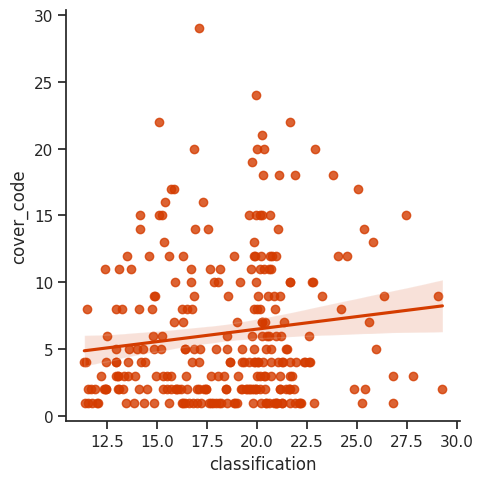

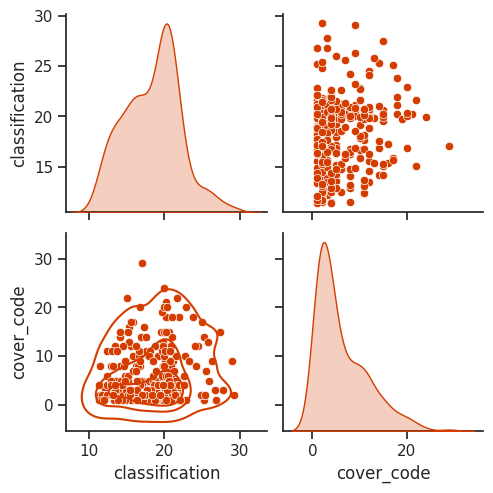

In [55]:
# sns.relplot(data=glad_sample_df, x='classification', y='b1')
# sns.pairplot(glad_sample_df, kind="hist") #kind="hist" kde


# To add color use this ## note it affects all cells
custom_palette2 = ["#d43c00"]
sns.set_palette(custom_palette2)


sns.lmplot(data=wri_sample_df,x = 'classification', y = 'cover_code', )

g = sns.pairplot(wri_sample_df, diag_kind="kde")
g.map_lower(sns.kdeplot, levels=4,)

# ETH

In [20]:
#/toggle off these two lines for bareground concerns
eth_add_gte = eth.gte(1).clip(ROI);
eth_add_gte_only = eth.updateMask(eth_add_gte)

###/eth
stacked_Comp_eth = Regression_Predicted_Image.addBands(eth_add_gte_only)
#print("stacked_Comp_eth", stacked_Comp_eth)
Map.addLayer(stacked_Comp_eth, {}, "stacked_Comp_eth")

##Random sample approach
rand_Pts_eth = ee.FeatureCollection.randomPoints(stacked_Comp_eth.geometry(), 1000, 42, 10)
#print("rand_Pts_eth", rand_Pts_eth)
Map.addLayer(rand_Pts_eth, {}, "rand_Pts_eth")

eth_sample = stacked_Comp_eth.sample(**
 {'region':rand_Pts_eth, 'scale':1, 'numPixels': 500000, 'seed':42,"geometries": True}
                                       )
# print("eth_sample", eth_sample.getInfo())
# print("eth_sample", eth_sample.first())
#Map.addLayer(eth_sample, {} , "eth_sample", False)

#Map

In [21]:
eth_sample_df = geemap.ee_to_df(eth_sample)
print("eth_sample_df", eth_sample_df)
y_true_eth = eth_sample_df['eth']
print('y_true', y_true_eth.shape)
y_pred_eth = eth_sample_df['classification']
print('y_pred', y_pred_eth.shape)

print("MAE",mean_absolute_error(y_true_eth,y_pred_eth))

print("MSE",mean_squared_error(y_true_eth,y_pred_eth))

r2 = r2_score(y_true_eth,y_pred_eth)
print("R2", r2)

print("RMSE",np.log(np.sqrt(mean_squared_error(y_true_eth,y_pred_eth))))

eth_sample_df      classification  eth
0         17.116911   31
1         11.804233   19
2         19.099873   18
3         23.221037   17
4         15.933549   14
..              ...  ...
927       13.272295   16
928       11.197894    5
929       20.141521   19
930       19.689651   22
931       16.089550   20

[932 rows x 2 columns]
y_true (932,)
y_pred (932,)
MAE 4.815464307310243
MSE 38.71263675198689
R2 -0.022313298187966124
RMSE 1.8280830388975826


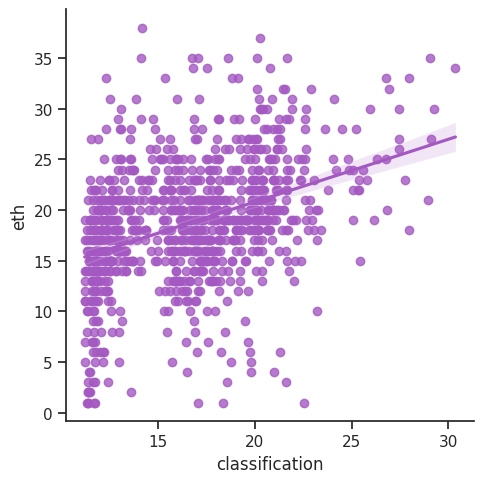

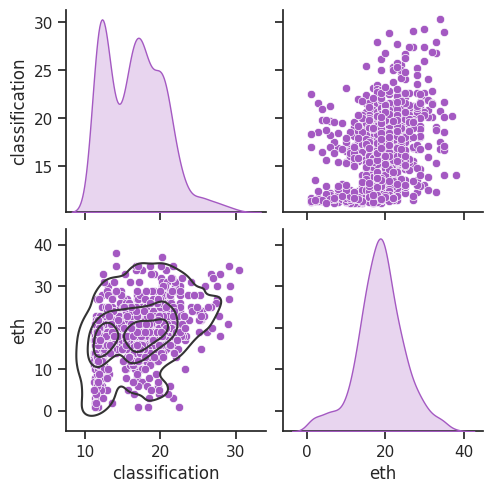

In [56]:
# sns.relplot(data=glad_sample_df, x='classification', y='b1')
# sns.pairplot(glad_sample_df, kind="hist") #kind="hist" kde


## ## to add color use this ## note it affects all cells
custom_palette3 = ["#a459c2"]
sns.set_palette(custom_palette3)

sns.lmplot(data=eth_sample_df,x = 'classification', y = 'eth')

g = sns.pairplot(eth_sample_df, diag_kind="kde")
g.map_lower(sns.kdeplot, levels=4, color=".2")

# UMD_TCH

In [43]:
#/toggle off these two lines for bareground concerns
UMD_TCH_add_gte = UMD_TCH.select('TCH_2021_b1').gte(1).clip(ROI);
UMD_TCH = UMD_TCH.updateMask(UMD_TCH_add_gte)

###/Glad
stacked_Comp_UMD_TCH = Regression_Predicted_Image.addBands(UMD_TCH)
#print("stacked_Comp_UMD_TCH", stacked_Comp_UMD_TCH)
Map.addLayer(stacked_Comp_UMD_TCH, {}, "stacked_Comp_UMD_TCH")

##Random sample approach
rand_Pts_UMD_TCH = ee.FeatureCollection.randomPoints(stacked_Comp_UMD_TCH.geometry(), 1000, 42, 10)
#print("rand_Pts_UMD_TCH", ranrand_Pts_UMD_TCHd_Pts)
Map.addLayer(rand_Pts_UMD_TCH, {}, "rand_Pts_UMD_TCH")

UMD_TCH_sample = stacked_Comp_UMD_TCH.sample(**
 {'region':rand_Pts_UMD_TCH, 'scale':1, 'numPixels': 500000, 'seed':42,"geometries": True}
                                       )
# print("UMD_TCH_sample", UMD_TCH_sample.getInfo())
# print("UMD_TCH_sample", UMD_TCH_sample.first())
# Map.addLayer(UMD_TCH_sample, {} , "UMD_TCH_sample", False)

# Map

UMD_TCH_sample {'type': 'FeatureCollection', 'columns': {'TCH_2021_b1': 'Short<0, 255>', 'classification': 'Float'}, 'properties': {'band_order': ['classification', 'TCH_2021_b1']}, 'features': [{'type': 'Feature', 'geometry': {'geodesic': False, 'type': 'Point', 'coordinates': [72.78998890722215, 34.40187762906478]}, 'id': '0', 'properties': {'TCH_2021_b1': 7, 'classification': 26.165712356567383}}, {'type': 'Feature', 'geometry': {'geodesic': False, 'type': 'Point', 'coordinates': [72.79108485186877, 34.397395035797025]}, 'id': '1', 'properties': {'TCH_2021_b1': 1, 'classification': 11.678093910217285}}, {'type': 'Feature', 'geometry': {'geodesic': False, 'type': 'Point', 'coordinates': [72.73036772181514, 34.402165089955695]}, 'id': '2', 'properties': {'TCH_2021_b1': 9, 'classification': 18.442556381225586}}, {'type': 'Feature', 'geometry': {'geodesic': False, 'type': 'Point', 'coordinates': [72.73333216225274, 34.4005301561386]}, 'id': '3', 'properties': {'TCH_2021_b1': 3, 'classif

Map(bottom=104919.0, center=[34.11294155709562, 73.4144720421936], controls=(WidgetControl(options=['position'…

In [44]:
UMD_TCH_df = geemap.ee_to_df(UMD_TCH_sample)
print("UMD_TCH_df", UMD_TCH_df)
y_true_UMD_TCH = UMD_TCH_df['TCH_2021_b1']
print('y_true_UMD_TCH', y_true_UMD_TCH.shape)
y_pred_UMD_TCH = UMD_TCH_df['classification']
print('y_pred_UMD_TCH', y_pred_UMD_TCH.shape)

print("MAE",mean_absolute_error(y_true_UMD_TCH,y_pred_UMD_TCH))

print("MSE",mean_squared_error(y_true_UMD_TCH,y_pred_UMD_TCH))

r2 = r2_score(y_true_UMD_TCH,y_pred_UMD_TCH)
print("R2", r2)

print("RMSE",np.log(np.sqrt(mean_squared_error(y_true_UMD_TCH,y_pred_UMD_TCH))))

UMD_TCH_df      TCH_2021_b1  classification
0             12       17.116911
1              8       11.804233
2              9       19.099873
3              9       18.442556
4              3       18.098837
..           ...             ...
626            6       18.649641
627            2       17.341579
628            4       16.915001
629            2       16.770065
630            6       12.763947

[631 rows x 2 columns]
y_true_UMD_TCH (631,)
y_pred_UMD_TCH (631,)
MAE 8.432969466631084
MSE 92.66919043194365
R2 -3.0852968793954094
RMSE 2.2645180297643774


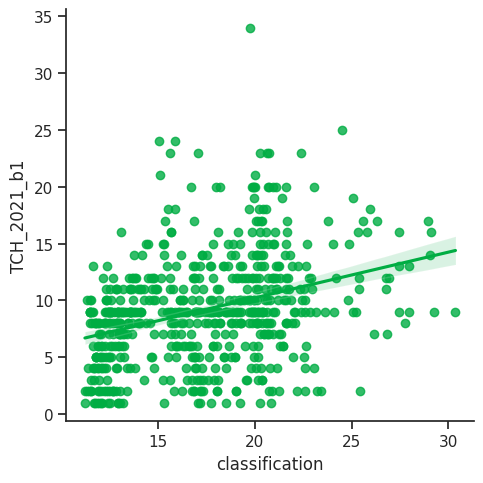

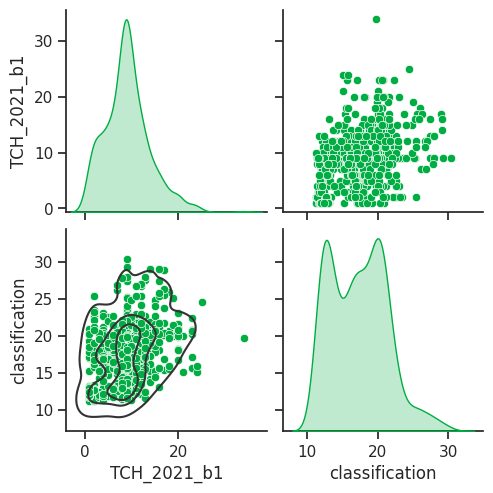

In [57]:

# sns.relplot(data=glad_sample_df, x='classification', y='b1')
# sns.pairplot(glad_sample_df, kind="hist") #kind="hist" kde

custom_palette4 = ["#00ad43"]
sns.set_palette(custom_palette4)


sns.lmplot(data=UMD_TCH_df,x = 'classification', y = 'TCH_2021_b1')

g = sns.pairplot(UMD_TCH_df, diag_kind="kde")
g.map_lower(sns.kdeplot, levels=4, color=".2")

# In Situ

In [ ]:
in_situ_out = in_situ #.filter(ee.Filter.lte('Max_Total_height', 9998)) //remove n/a
print("in_situ_out", in_situ_out)
Map.addLayer(in_situ_out, {}, "in_situ_out", False)

stacked_Comp_insitu = Regression_Predicted_Image.sampleRegions(**{'collection': in_situ_out, "properties": ["Max_Total_height"], 'scale': 10});

Map.addLayer(stacked_Comp_insitu, {}, "stacked_Comp_insitu", False)
# print('stacked_Comp_insitu', stacked_Comp_insitu);

# Map

in_situ_out ee.FeatureCollection({
  "functionInvocationValue": {
    "functionName": "Collection.loadTable",
    "arguments": {
      "tableId": {
        "constantValue": "users/tjm0042/PHD/SA_Rest/Height_Avg_max_xycsv"
      }
    }
  }
})
stacked_Comp_insitu ee.FeatureCollection({
  "functionInvocationValue": {
    "functionName": "Image.sampleRegions",
    "arguments": {
      "collection": {
        "functionInvocationValue": {
          "functionName": "Collection.loadTable",
          "arguments": {
            "tableId": {
              "constantValue": "users/tjm0042/PHD/SA_Rest/Height_Avg_max_xycsv"
            }
          }
        }
      },
      "image": {
        "functionInvocationValue": {
          "functionName": "Image.load",
          "arguments": {
            "id": {
              "constantValue": "projects/servir-sco-assets/assets/SCO_HKH/KP_Height_Prelim/Regression_Predicted_Image_PFI_Test_ROI"
            }
          }
        }
      },
      "properties": {

Map(bottom=104715.0, center=[34.344342372627665, 72.75989984828747], controls=(WidgetControl(options=['positio…

In [ ]:
insitu_sample_df = geemap.ee_to_df(stacked_Comp_insitu)
#print("insitu_sample_df", insitu_sample_df)
y_true_in = insitu_sample_df['Max_Total_height']
print('y_true', y_true_in.shape)
y_pred_in = insitu_sample_df['classification']
print('y_pred', y_pred_in.shape)

print("MAE",mean_absolute_error(y_true_in,y_pred_in))

print("MSE",mean_squared_error(y_true_in,y_pred_in))

r2 = r2_score(y_true_in,y_pred_in)
print("R2", r2)

print("RMSE",np.log(np.sqrt(mean_squared_error(y_true_in,y_pred_in))))

KeyError: 'Max_Total_height'

In [ ]:
# sns.relplot(data=glad_sample_df, x='classification', y='b1')
# sns.pairplot(glad_sample_df, kind="hist") #kind="hist" kde

sns.lmplot(data=insitu_sample_df,x = 'classification', y = 'Max_Total_height')

g = sns.pairplot(insitu_sample_df, diag_kind="kde")
g.map_lower(sns.kdeplot, levels=4, color=".2")

KeyError: "None of [Index(['Max_Total_height', 'classification'], dtype='object')] are in the [columns]"

# Comp All

DF table set up

In [58]:
b1 = ["Glad"]

length = 531

for i in range(length - len(b1)):
    b1.append(b1[i])

print(b1)
######
cover_code = ["WRI"]

length = 283

for i in range(length - len(cover_code)):
     cover_code.append(cover_code[i])

print(cover_code)

#######
cover_code_eth = ["eth"]

length = 931

for i in range(length - len(cover_code_eth)):
     cover_code_eth.append(cover_code_eth[i])

print(cover_code_eth)

########
Max_Total_height = ["TCH_2021_b1"]

length = 631

for i in range(length - len(Max_Total_height)):
     Max_Total_height.append(Max_Total_height[i])

print(Max_Total_height)


# ########
# Max_Total_height = ["In_situ"]

# length = 26

# for i in range(length - len(Max_Total_height)):
#      Max_Total_height.append(Max_Total_height[i])

# print(Max_Total_height)

group = np.hstack((b1, cover_code, cover_code_eth, Max_Total_height))#, Max_Total_height))
print(group)

['Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad',

In [59]:
true = np.concatenate((y_true_glad, y_true_wri, y_true_eth, y_true_UMD_TCH),axis=0)#, y_true_in),axis=0)
pred = np.concatenate((y_pred_glad, y_pred_wri, y_pred_eth, y_pred_UMD_TCH),axis=0)#, y_pred_in),axis=0)

df = pd.DataFrame()
df['true'] = pd.Series(true)
df['pred'] = pd.Series(pred)
df['variance'] = df.var(1)
df['group'] = pd.Series(group)

df

true       pred    variance        group
0       11  15.602602   10.591973         Glad
1        7  21.222681  101.142328         Glad
2        8  26.165712  164.996553         Glad
3        9  16.258160   26.340441         Glad
4       11  20.041582   40.875104         Glad
...    ...        ...         ...          ...
2372     6  18.649641   80.006709  TCH_2021_b1
2373     2  17.341579  117.682030  TCH_2021_b1
2374     4  16.915001   83.398624  TCH_2021_b1
2375     2  16.770065  109.077415  TCH_2021_b1
2376     6  12.763947   22.875493          NaN

[2377 rows x 4 columns]

<Axes: xlabel='pred', ylabel='true'>

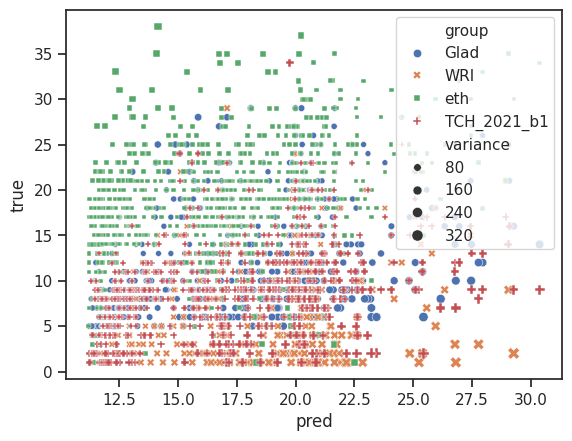

In [60]:
sns.scatterplot(data=df, x="pred", y="true", hue="group", style="group", size="variance", palette="deep")

<Axes: xlabel='pred', ylabel='true'>

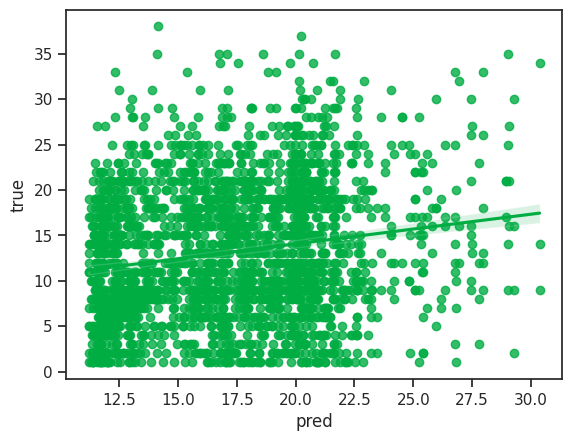

In [61]:
sns.regplot(data=df, x="pred", y="true")

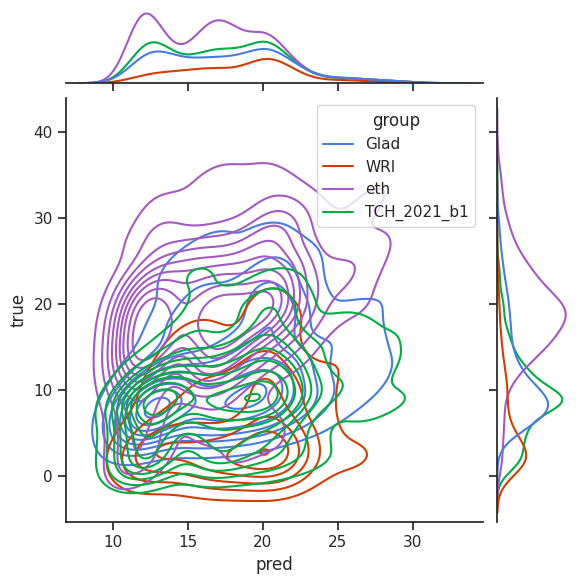

In [67]:
import seaborn as sns
sns.set_theme(style="ticks")
# Show the joint distribution using kernel density estimation

pallete_Comp_all = ["#467ce0","#d43c00","#a459c2", "#00ad43"]
sns.set_palette(pallete_Comp_all)

g = sns.jointplot(
    data=df,
    x="pred", y="true", hue="group", hue_order= ["Glad", "WRI", "eth", "TCH_2021_b1"],  palette=sns.color_palette(pallete_Comp_all, 4),
    kind="kde",
)

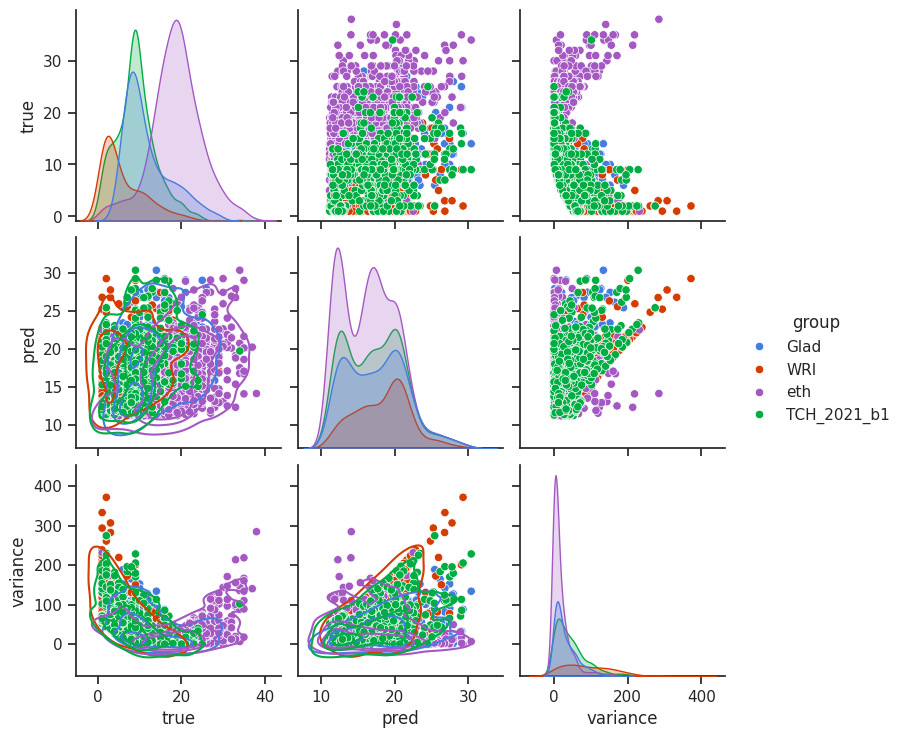

In [68]:
g = sns.pairplot(df,hue="group", diag_kind="kde")
g.map_lower(sns.kdeplot, levels=4, color=".2")

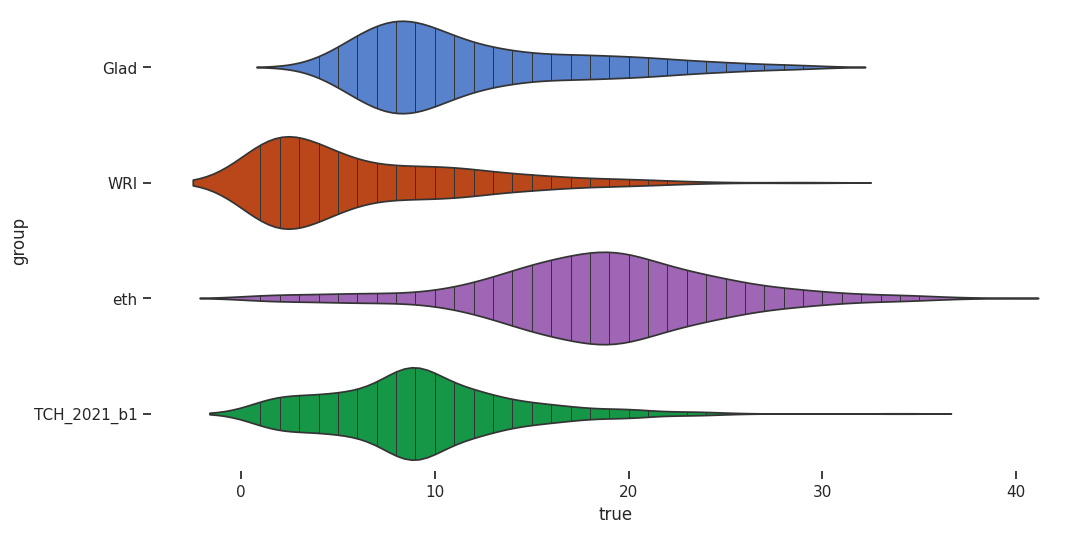

In [70]:
from matplotlib import pyplot as plt
import seaborn as sns

pallete_Comp_all = ["#467ce0","#d43c00","#a459c2", "#00ad43"]
sns.set_palette(pallete_Comp_all)


figsize = (12, 1.2 * len(df['group'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='true', y='group', inner='stick', palette=sns.color_palette(pallete_Comp_all, 4))
sns.despine(top=True, right=True, bottom=True, left=True)

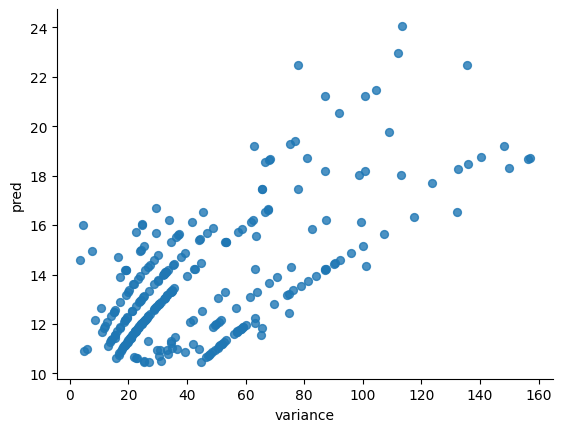

In [ ]:
# from matplotlib import pyplot as plt
# df.plot(kind='scatter', x='variance', y='pred', s=32, alpha=.8)
# plt.gca().spines[['top', 'right',]].set_visible(False)
# #plt.plot([0,100], [0,100])